# Running experiments

In this notebook we perform model selection and hyperparameter search for the segmentation model. The ultimate goal of this survey is to keep track of already explored configurations and how they perform, in order to select the best configuration for deployment later.

We use MLflow model tracking for such a purpose.

## Prepare notebook

We now set the current working directory, and load parameters from a configuration file.

In [1]:
import os

def set_directory(using_colab):
  """
  Set main directory to be just one level before the
  src and notebooks directories. It handles this differently depending whether
  we are in colab or local. If we are in colab we also mount the drive
  """

  if using_colab:

      if os.getcwd() == '/content':  # Starting folder by default

        # Mount drive if run function for the first time
        from google.colab import drive
        drive.mount('/content/drive')

      # Change dir to where project is located
      os.chdir(f"/content/drive/MyDrive/covision/segmentation")
  else:
    if 'models_seg' in os.listdir(os.getcwd()) or 'models_cla' in os.listdir(os.getcwd()): # Already in desired location
      pass
    else:
      os.chdir('../')  # Go back one level (from notebooks_seg to segmentation or classification folder)

  cwd = os.getcwd()
  print(f'Current working directory: {cwd}\n')

  return cwd

In [2]:
import sys
import os
import yaml
import argparse

# Check whether we are in colab or local
using_colab = True if 'google.colab' in sys.modules else False
# Set current working directory to be one level above the src folder
cwd = set_directory(using_colab)
# Read arguments from dict and store them as Namespace
if 'config_seg.yaml' in os.listdir(cwd):
  with open('config_seg.yaml', 'r') as f:
      args = argparse.Namespace(**yaml.safe_load(f))

  # Update directories
  for k in ['data_dir', 'save_path']:
    args.data_args[k] = os.path.join(cwd, args.data_args[k])
  # Split configuration file
  data_args = argparse.Namespace(**args.data_args)
  transformation_args = argparse.Namespace(**args.transformation_args)
  evaluation_args = argparse.Namespace(**args.evaluation_args)

# Add src folder and one level above to PYTHONPATH
sys.path.insert(0, 'src_seg/')
sys.path.insert(0, './../')

# To reaload packages and modules automatically! Super useful to avoid double coding
%load_ext autoreload
%autoreload 2

Current working directory: /home/guybrush/Tomaco/covision/segmentation



## Setup server and define experiment

In [3]:
if using_colab:
  os.system("pip3 install pyngrok")  # Create remote tunnel using ngrok.com to allow local port access
  os.system("pip3 install mlflow")

import mlflow
from pathlib import Path

from utils.mlflow_utils import initiate_mlflow_server, create_mlflow_experiment

if 'models_seg' in os.listdir(os.getcwd()):
  os.chdir('models_seg')

In [5]:
# Initiate mlflow sever to default location http://127.0.0.1:5000
initiate_mlflow_server(using_colab)

# Experiment name
experiment_name = "MaskRCNN_ResNet50_Full_Aconag"
# Experiment description that will appear in the UI
experiment_description = (
    "This is the kit and membrane segmentation project.\n"
    "This experiment uses a MaskRCNN with ResNet50 backbone architecture.\n"
    "This experiment uses the full aconag trainset for trainning."
)
# Searchable tags that define characteristics of the different runs inside this experiment.
experiment_tags = {
    "project_name": "kit_membrane_segmentation",
    "architecture": "maskrcnn_resnet50",
    "data": "full_aconag",
    "mlflow.note.content": experiment_description,
}

# Create experiment
experiment_id = create_mlflow_experiment(experiment_name, tags=experiment_tags)

# Set experiment
experiment = mlflow.set_experiment(experiment_name=experiment_name)

5000/tcp:           
Running the mlflow server failed. Please see the logs above for details.


 15903 15905 15906 15907 15908

[2024-03-28 12:43:45 +0100] [16070] [INFO] Starting gunicorn 21.2.0
[2024-03-28 12:43:45 +0100] [16070] [INFO] Listening at: http://127.0.0.1:5000 (16070)
[2024-03-28 12:43:45 +0100] [16070] [INFO] Using worker: sync
[2024-03-28 12:43:45 +0100] [16072] [INFO] Booting worker with pid: 16072
[2024-03-28 12:43:45 +0100] [16073] [INFO] Booting worker with pid: 16073
[2024-03-28 12:43:45 +0100] [16074] [INFO] Booting worker with pid: 16074
[2024-03-28 12:43:45 +0100] [16075] [INFO] Booting worker with pid: 16075


RESOURCE_ALREADY_EXISTS: Experiment 'MaskRCNN_ResNet50_Full_Aconag' already exists.


Running the mlflow server failed. Please see the logs above for details.


## Train, evaluate and MLflow run

we now train a model with a specific dataset and set of hyperparameters, evaluate it on a validation set and log the relevant parameters and characteristics using MLflow

In [6]:
from model_train_seg import TrainerSegmentation
from model_evaluate_seg import EvalSegmentation
from utils_seg.visualization import plot_metrics

/usr/lib/python3/dist-packages/mpmath/ctx_mp_python.py:873: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if other is 0:
/usr/lib/python3/dist-packages/mpmath/ctx_mp_python.py:967: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if other is 0:
/usr/lib/python3/dist-packages/sympy/solvers/diophantine.py:3188: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if feasible is 1:  # it's prime and k == 2


In [7]:
# Parameters and hyperparameters
parameters = {
    'kit_id': ['aconag'],
    'val_set': 'val',
    'shots': [None],
    'seed': 42,
    'batch_size': 4,
    'num_workers': 2,
    'hidden_size': 256,
    'lr': 5e-5,
    'scheduler_step': None,
    'scheduler_gamma': 0.5,
    'epochs': 10
}

In [8]:
# Train
trainer = TrainerSegmentation(args, parameters, do_validation=True)
trainer.train(save_state_bool=True)

Using cpu device
Random seed set as 42
Loading data...
Loaded 25 image and mask paths for aconag kit(s) in train data mode
Loaded 7 image and mask paths for aconag kit(s) in val data mode


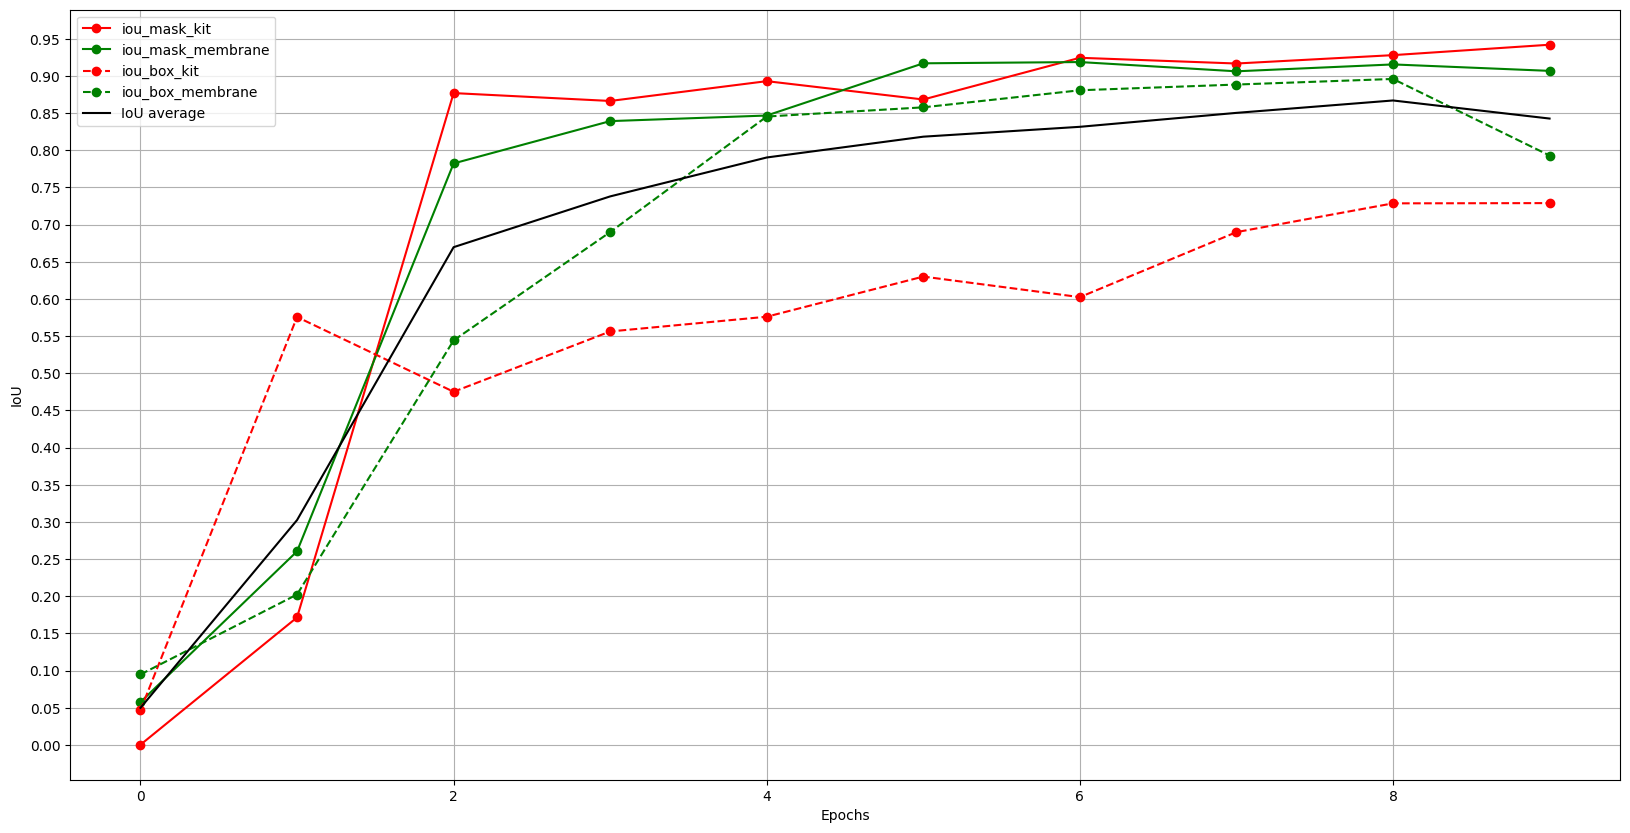

In [23]:
# Plot metrics
metrics_train_df, metrics_val_df = trainer.get_metrics()
plot_metrics(metrics_val_df)

In [113]:
# Evaluate best model on trainingset to get accuracy
tester = EvalSegmentation(args, model=trainer.best_model, n_batches=4, n_workers=2, device=None)
metrics_train_df = tester.evaluate(kit_id=trainer.get_parameters['kit_id'], data_mode='train')
metrics_val_df = tester.evaluate(kit_id=trainer.get_parameters['kit_id'], data_mode='val')

Loaded 25 image and mask paths for aconag kit(s) in train data mode


  0%|          | 0/7 [00:00<?, ?it/s]

Mean metrics
scores_kit            0.923783
scores_membrane       0.955015
iou_masks_kit         0.919733
iou_masks_membrane    0.907439
iou_boxes_kit         0.713178
iou_boxes_membrane    0.889967
dtype: float64
iou_mean: 0.8576
Loaded 7 image and mask paths for aconag kit(s) in val data mode


  0%|          | 0/2 [00:00<?, ?it/s]

Mean metrics
scores_kit            0.932251
scores_membrane       0.951316
iou_masks_kit         0.928656
iou_masks_membrane    0.915307
iou_boxes_kit         0.732424
iou_boxes_membrane    0.894750
dtype: float64
iou_mean: 0.8678


In [117]:
# Start MLflow run
with mlflow.start_run() as run:

    # Log hyperparameters
    mlflow.log_params(trainer.get_parameters)
    mlflow.log_params(trainer.args.transformation_args)
    mlflow.log_params({'n_trainset': len(metrics_train_df),
                       'n_valset': len(metrics_val_df)})

    # Log metrics
    train_means = metrics_train_df.mean().to_dict()
    train_iou_mean = float(metrics_train_df.iloc[:, 2:].mean().mean())
    val_means = metrics_val_df.mean().to_dict()
    val_iou_mean = float(metrics_val_df.iloc[:, 2:].mean().mean())

    for k, v in train_means.items():
      mlflow.log_metric('train_' + k, v)
    for k, v in val_means.items():
      mlflow.log_metric('val_' + k, v)
    mlflow.log_metric("train_best_iou_mean", train_iou_mean)
    mlflow.log_metric("val_best_iou_mean", val_iou_mean)
    mlflow.log_metric("epoch_of_best_iou_mean", trainer.best_epoch)

    # Log model
    mlflow.pytorch.log_model(pytorch_model=trainer.best_model, artifact_path='model')

2024/03/28 09:40:42 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.2.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/03/28 09:40:51 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.17.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.17.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/03/28 09:40:51 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.4.23+cuda12.cudnn89) contains a local version label (+cuda12.cudnn89). MLflow logged a pip requirement for this package as 'jaxlib==0.4.23' without t

## Evaluate on unseen data

When obtained the best model according to the validation set, we evaluate the model on unseen data such as test sets or other kits. We store the relevant parameters, metrics and figures as artifacts inside the `mlruns` folder.

The best model is also registered in the MLflow model registry to specify that such a model finished with the deployment stage. Currently, this registration mus be done manually using the MLflow ui.

In [118]:
# Load model from run_id
run_id = 'dfb1f51896024a33b6c6681e01551424' # run.info.run_id
model = mlflow.pytorch.load_model(model_uri=f"runs:/{run_id}/model")

# Path to save evaluation artifacts
save_path = os.path.join(cwd, f'models_seg/mlruns/{experiment_id}/{run_id}/artifacts/model_evaluation')

In [119]:
tester = EvalSegmentation(args, model=model, device=None)

In [122]:
metrics_test_df = tester.evaluate(kit_id=['aconag'], data_mode='test', save_bool=True, save_path=save_path)

Loaded 8 image and mask paths for aconag kit(s) in test data mode


  0%|          | 0/4 [00:00<?, ?it/s]

File /content/drive/MyDrive/covision/segmentation/models_seg/mlruns/826020019003400621/dfb1f51896024a33b6c6681e01551424/artifacts/model_evaluation/aconag_test_stats.csv already exists! Do you want to overwrite it? (y/n): y
The file will be overwritten!
File /content/drive/MyDrive/covision/segmentation/models_seg/mlruns/826020019003400621/dfb1f51896024a33b6c6681e01551424/artifacts/model_evaluation/aconag_test_iou_mean.txt already exists! Do you want to overwrite it? (y/n): y
The file will be overwritten!
Mean metrics
scores_kit            0.920209
scores_membrane       0.930812
iou_masks_kit         0.906785
iou_masks_membrane    0.916602
iou_boxes_kit         0.699172
iou_boxes_membrane    0.895728
dtype: float64
iou_mean: 0.8546


In [123]:
_ = tester.evaluate(kit_id=['deepblueag', 'aconag'], data_mode='all', save_bool=True, save_path=save_path)

Loaded 80 image and mask paths for deepblueag-aconag kit(s) in all data mode


  0%|          | 0/40 [00:00<?, ?it/s]

Mean metrics
scores_kit            0.919110
scores_membrane       0.947050
iou_masks_kit         0.913431
iou_masks_membrane    0.902215
iou_boxes_kit         0.714807
iou_boxes_membrane    0.867039
dtype: float64
iou_mean: 0.8494


ValueError: too many values to unpack (expected 2)

In [124]:
_ = tester.evaluate(kit_id=['deepblueag', 'aconag'], data_mode='test', save_bool=True, save_path=save_path)

Loaded 16 image and mask paths for deepblueag-aconag kit(s) in test data mode


  0%|          | 0/8 [00:00<?, ?it/s]

Mean metrics
scores_kit            0.925231
scores_membrane       0.935017
iou_masks_kit         0.916075
iou_masks_membrane    0.911028
iou_boxes_kit         0.705526
iou_boxes_membrane    0.871052
dtype: float64
iou_mean: 0.8509
